In [1]:
%load_ext autoreload
%autoreload 2

import ast
import os
import sys
import requests as req
import json
import multiprocessing as mp


from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

new_path = os.getcwd().replace('/notebooks', '')
print(f'Adding {new_path} to sys.path')

if new_path not in sys.path:
    sys.path.append(new_path)

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 10})

# Local imports
from curvemetrics.src.classes.datahandler import DataHandler
from curvemetrics.src.classes.datafetcher import DataFetcher
from curvemetrics.src.classes.metricsprocessor import MetricsProcessor
from curvemetrics.src.plotting.plot import bocd_plot_comp
from curvemetrics.src.classes.model import BOCD

Adding /root/curve-lp-metrics to sys.path


In [2]:
scaler = StandardScaler()
datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()
metricsprocessor = MetricsProcessor(pool_metadata, token_metadata)

In [3]:
pool = "0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7" # UST pool
start_ts = datetime.timestamp(datetime(2023, 1, 1))
end_ts = datetime.timestamp(datetime(2023, 5, 1))
swaps_data = datahandler.get_swaps_data(pool, start_ts, end_ts)
tokens = set(swaps_data['tokenBought']).union(set(swaps_data['tokenSold']))

# Aggregate LP Markouts

<Axes: xlabel='timestamp'>

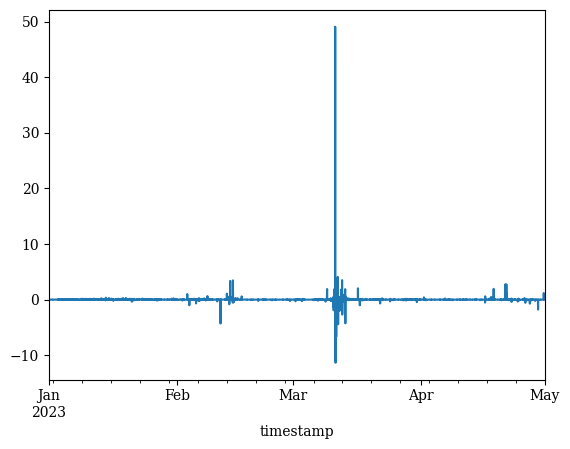

In [4]:
FREQ = '1h'
NORMALIZE = False
STANDARDIZE = True

markouts_agg = datahandler.get_pool_X('300.Markout', pool, start_ts, end_ts, FREQ, normalize=NORMALIZE, standardize=STANDARDIZE)
markouts_agg.plot()

# Individual Taker Markouts

- Input: Period
- Read current takers table
- For each pool:
    - Compute markouts
    - Add markouts to takers table
- Warning: don't double count any swaps

In [5]:
takers = datahandler.get_takers()
takers

,amountBought,amountSold,cumulativeMarkout,meanMarkout,count,windowSize
buyer,,,,,,
0xdb886bf718fbf354eb4202b03ad13b1cafb01276,5.064775e+07,5.045182e+07,1.720375e+07,312795.532169,55.0,86400
0xeef86c2e49e11345f1a693675df9a38f7d880c8f,1.818329e+09,1.849629e+09,1.696571e+07,2079.130932,8160.0,86400
0xdef171fe48cf0115b1d80b88dc8eab59176fee57,1.356119e+09,1.364734e+09,1.036715e+07,840.193754,12339.0,86400
0x99a58482bd75cbab83b27ec03ca68ff489b5788f,2.932357e+09,2.929860e+09,9.217716e+06,356.460653,25859.0,86400
0x22f9dcf4647084d6c31b2765f6910cd85c178c18,2.545348e+09,2.558772e+09,9.016436e+06,821.842708,10971.0,86400
...,...,...,...,...,...,...
0x59964a45f2efbb001859ab57e3e4cdcfb7f3d2c0,1.759693e+08,1.730000e+08,-1.044037e+07,-696024.896271,15.0,86400
0x3cf4d7e888425a37c8bbfce75b5741fc84cfabc8,2.844192e+07,2.325099e+07,-1.049308e+07,-147789.896204,71.0,86400
0x2057cfb9fd11837d61b294d514c5bd03e5e7189a,8.605303e+08,8.225686e+08,-1.313833e+07,-5080.559277,2586.0,86400


In [6]:
sharks = datahandler.get_sharks(top=0.9)
print(len(sharks), 'top 10% sharks')
sharks

2473 top 10% sharks


array(['0xdb886bf718fbf354eb4202b03ad13b1cafb01276',
       '0xeef86c2e49e11345f1a693675df9a38f7d880c8f',
       '0xdef171fe48cf0115b1d80b88dc8eab59176fee57', ...,
       '0x83544f6a48ae535350ec73c702758e40493ceb45',
       '0xc6023984f0ef1d2f61a1b4880f5a06e59e854738',
       '0xab8ee0687e88d5fecf0c1362c237c428f7a3bab1'], dtype=object)

In [7]:
sharkflows = datahandler.get_pool_X('sharkFlow', pool, start_ts, end_ts, timedelta(hours=1), standardize=True)
swapflows = datahandler.get_pool_X('netSwapFlow', pool, start_ts, end_ts, timedelta(hours=1), standardize=True)

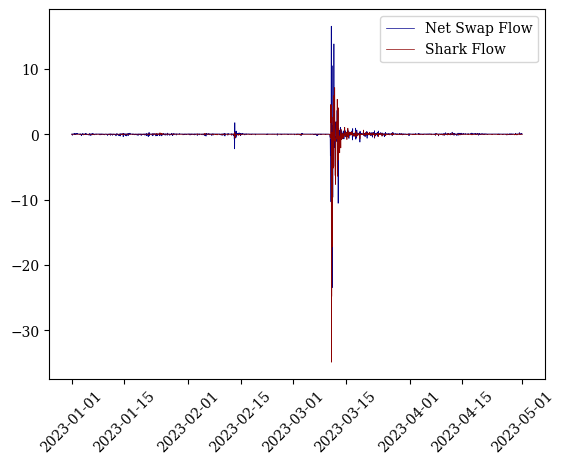

In [8]:
f, ax = plt.subplots()
ax.plot(swapflows, linewidth=0.5, color='darkblue', label='Net Swap Flow')
ax.plot(sharkflows, linewidth=0.5, color='darkred', label='Shark Flow')
ax.tick_params(axis='x', rotation=45)
ax.legend()

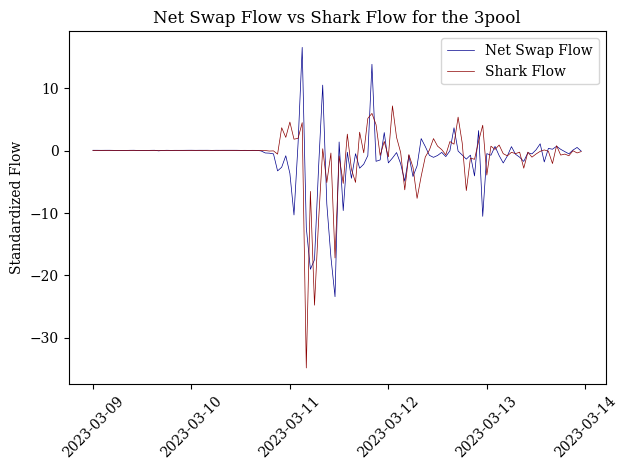

In [11]:
f, ax = plt.subplots()
ax.plot(swapflows.loc['2023-03-09':'2023-03-13'], linewidth=0.5, color='darkblue', label='Net Swap Flow')
ax.plot(sharkflows.loc['2023-03-09':'2023-03-13'], linewidth=0.5, color='darkred', label='Shark Flow')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Net Swap Flow vs Shark Flow for the 3pool')
ax.set_ylabel('Standardized Flow')
ax.legend()
f.tight_layout()
f.savefig('../figs/sharflow_vs_swapflow.png')

In [80]:
frxeth = "0xa1f8a6807c402e4a15ef4eba36528a3fed24e577"
cvxcrv = '0x971add32ea87f10bd192671630be3be8a11b8623'

lp_share_price = datahandler.get_pool_metric(frxeth, 'lpSharePrice', start_ts, end_ts)
cps = datahandler.get_changepoints(frxeth, 'baseline', 'baseline', start_ts, end_ts)
print(cps)

timestamp
2023-01-07    1673049600
2023-01-21    1674259200
2023-02-04    1675468800
2023-02-18    1676678400
2023-03-04    1677888000
2023-03-18    1679097600
2023-04-01    1680307200
2023-04-15    1681516800
2023-04-29    1682726400
Name: changepoints, dtype: int64


<Axes: xlabel='timestamp'>

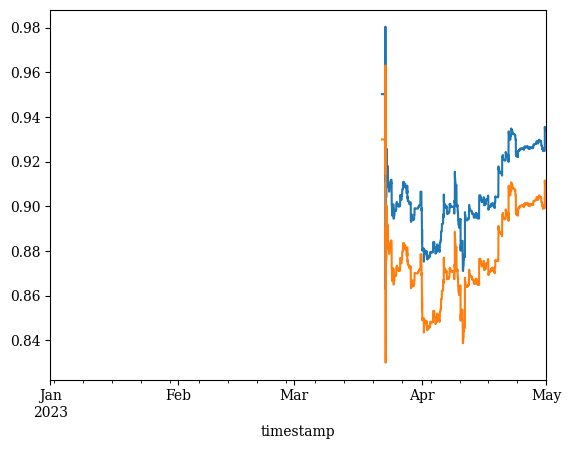

In [77]:
crv_price = datahandler.get_ohlcv_data(datahandler.token_ids['CRV'], start=start_ts, end=end_ts)['close']
normed = lp_share_price / crv_price
normed.plot()
cvxcrv_price = datahandler.get_ohlcv_data(datahandler.token_ids['cvxCRV'], start=start_ts, end=end_ts)['close']
cvxcrv_price.plot()

<Axes: xlabel='timestamp'>

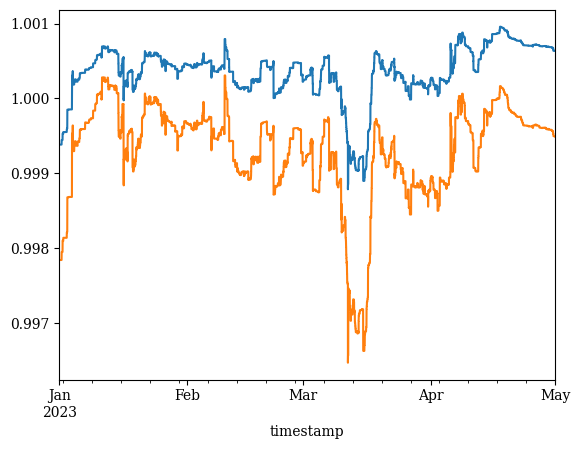

In [82]:
eth_price = datahandler.get_ohlcv_data(datahandler.token_ids['ETH'], start=start_ts, end=end_ts)['close']
normed = lp_share_price / eth_price
normed.plot()
frxeth_price = datahandler.get_ohlcv_data(datahandler.token_ids['frxETH'], start=start_ts, end=end_ts)['close']
frxeth_price.plot()